In [1]:
import findspark
findspark.init()

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Project").getOrCreate()
    
spark

In [3]:
sc = spark.sparkContext

In [4]:
from pyspark.sql import SQLContext

sqlContext = SQLContext(sc)
data = sqlContext.read.format("com.databricks.spark.csv").option("header", "true").load("*.csv")

In [5]:
data.printSchema()
data.count()

root
 |-- _c0: string (nullable = true)
 |-- ID: string (nullable = true)
 |-- Case Number: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Block: string (nullable = true)
 |-- IUCR: string (nullable = true)
 |-- Primary Type: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Location Description: string (nullable = true)
 |-- Arrest: string (nullable = true)
 |-- Domestic: string (nullable = true)
 |-- Beat: string (nullable = true)
 |-- District: string (nullable = true)
 |-- Ward: string (nullable = true)
 |-- Community Area: string (nullable = true)
 |-- FBI Code: string (nullable = true)
 |-- X Coordinate: string (nullable = true)
 |-- Y Coordinate: string (nullable = true)
 |-- Year: string (nullable = true)
 |-- Updated On: string (nullable = true)
 |-- Latitude: string (nullable = true)
 |-- Longitude: string (nullable = true)
 |-- Location: string (nullable = true)



7941286

In [6]:
import datetime
from pyspark.sql.functions import *

data = data.withColumn('date_time', to_timestamp('Date', 'MM/dd/yyyy hh:mm:ss a'))\
       .withColumn('month', trunc('date_time', 'YYYY')) 


data = data.withColumn('hour', hour(data['date_time']))

data = data.withColumn('week_day', dayofweek(data['date_time']))\
                 .withColumn('year_month', month(data['date_time']))\
                 .withColumn('month_day', dayofmonth(data['date_time']))\
                 .withColumn('date_number', datediff(data['date_time'], to_date(lit('2001-01-01'), format='yyyy-MM-dd')))

In [7]:
from pyspark.sql.functions import col

data = data.distinct()
data.where(col("Case Number").isNotNull())

data.count()

6170816

In [8]:
crime_type = data.groupBy("Primary Type").count().sort("count",ascending=False)


# crime_type.show(truncate=False)


In [9]:

# crime_type.show(truncate=False)

[Text(0,0.5,'Primary Type'), Text(0.5,0,'Crimes Record Count')]

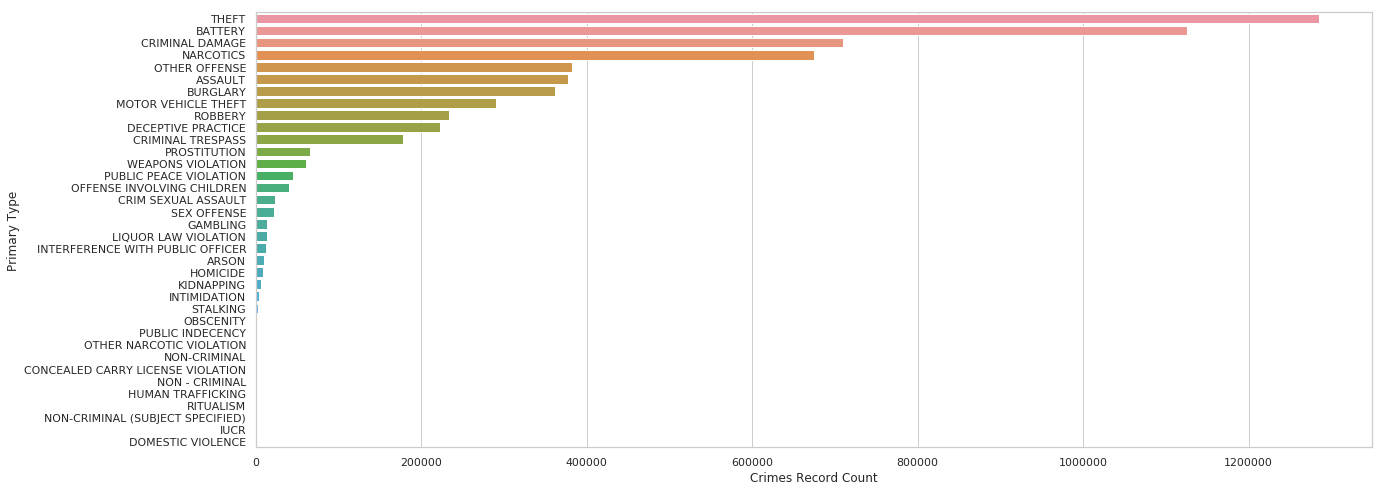

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

df = crime_type.toPandas()

plt.rcParams["figure.figsize"] = [20, 8]

sns.set(style="whitegrid")
sns.set_color_codes("pastel")

#sns.despine(left=True, bottom=True)
type_graph = sns.barplot(x='count', y='Primary Type', data=df)
type_graph.set(ylabel="Primary Type", xlabel="Crimes Record Count")

In [11]:
selected_features = [
 'Location Description',
 'Arrest',
 'Domestic',
 'Beat',
 'District',
 'Ward',
 'Community Area',
 'FBI Code',
 'hour',
 'week_day',
 'year_month',
 'month_day',
 'date_number']

In [12]:
df = data.select(selected_features)
df.show()

+--------------------+------+--------+----+--------+----+--------------+--------+----+--------+----------+---------+-----------+
|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|hour|week_day|year_month|month_day|date_number|
+--------------------+------+--------+----+--------+----+--------------+--------+----+--------+----------+---------+-----------+
|            SIDEWALK| False|   False| 324|     3.0| 5.0|          69.0|     04B|  20|       2|         4|        3|       1918|
|SCHOOL, PUBLIC, B...|  True|   False| 414|     4.0| 8.0|          43.0|      18|  11|       5|         3|        2|       1886|
|           RESIDENCE| False|   False|1524|    15.0|37.0|          25.0|      06|   0|       5|         7|       14|       1655|
|              STREET| False|    True| 512|     5.0|34.0|          49.0|     08B|  23|       5|         4|        6|       1921|
|        CTA PLATFORM|  True|   False|2431|    24.0|49.0|           1.0|      11|   7|       4|  

In [13]:
feature_level_count_dic = []

for feature in selected_features:
    print('Analysing %s' % feature)
    levels_list_df = df.select(feature).distinct()
    feature_level_count_dic.append({'feature': feature, 'level_count': levels_list_df.count()})

Analysing Location Description
Analysing Arrest
Analysing Domestic
Analysing Beat
Analysing District
Analysing Ward
Analysing Community Area
Analysing FBI Code
Analysing hour
Analysing week_day
Analysing year_month
Analysing month_day
Analysing date_number


In [14]:
import pandas as pd

pd.DataFrame(feature_level_count_dic).sort_values(by='level_count', ascending=False)


,feature,level_count
12,date_number,5863
3,Beat,305
0,Location Description,174
6,Community Area,80
5,Ward,52
11,month_day,32
4,District,28
7,FBI Code,27
8,hour,25
10,year_month,13


In [15]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
df_feat = data.na.drop(subset=selected_features)

df_feat.show()

+----+-------+-----------+--------------------+--------------------+----+------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+-------------------+----------+----+--------+----------+---------+-----------+
| _c0|     ID|Case Number|                Date|               Block|IUCR|      Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|    Latitude|    Longitude|            Location|          date_time|     month|hour|week_day|year_month|month_day|date_number|
+----+-------+-----------+--------------------+--------------------+----+------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+-----------

In [16]:
for feature in feature_level_count_dic:
    indexer = StringIndexer(inputCol=feature['feature'], outputCol='%s_indexed' % feature['feature'])
    print('Fitting feature "%s"' % feature['feature'])
    model = indexer.fit(df_feat)
    print('Transforming "%s"' % feature['feature'])
    df_feat = model.transform(df_feat)

Fitting feature "Location Description"
Transforming "Location Description"
Fitting feature "Arrest"
Transforming "Arrest"
Fitting feature "Domestic"
Transforming "Domestic"
Fitting feature "Beat"
Transforming "Beat"
Fitting feature "District"
Transforming "District"
Fitting feature "Ward"
Transforming "Ward"
Fitting feature "Community Area"
Transforming "Community Area"
Fitting feature "FBI Code"
Transforming "FBI Code"
Fitting feature "hour"
Transforming "hour"
Fitting feature "week_day"
Transforming "week_day"
Fitting feature "year_month"
Transforming "year_month"
Fitting feature "month_day"
Transforming "month_day"
Fitting feature "date_number"
Transforming "date_number"


In [17]:

response_indexer = StringIndexer(inputCol='Primary Type', outputCol='primary_type_indexed')
response_model = response_indexer.fit(df_feat)
df_feat = response_model.transform(df_feat)

In [18]:
indexed_features = ['%s_indexed' % fc['feature'] for fc in feature_level_count_dic]
indexed_features

['Location Description_indexed',
 'Arrest_indexed',
 'Domestic_indexed',
 'Beat_indexed',
 'District_indexed',
 'Ward_indexed',
 'Community Area_indexed',
 'FBI Code_indexed',
 'hour_indexed',
 'week_day_indexed',
 'year_month_indexed',
 'month_day_indexed',
 'date_number_indexed']

In [19]:
assembler = VectorAssembler(inputCols=indexed_features, outputCol='features')
vectorized_df_dates = assembler.transform(df_feat)

In [20]:
vectorized_df_dates.take(1)


[Row(_c0='15', ID='4673643', Case Number='HM270077', Date='04/03/2006 08:09:00 PM', Block='073XX S WOODLAWN AVE', IUCR='0420', Primary Type='BATTERY', Description='AGGRAVATED:KNIFE/CUTTING INSTR', Location Description='SIDEWALK', Arrest='False', Domestic='False', Beat='324', District='3.0', Ward='5.0', Community Area='69.0', FBI Code='04B', X Coordinate='1185483.0', Y Coordinate='1856655.0', Year='2006', Updated On='04/15/2016 08:55:02 AM', Latitude='41.761804069', Longitude='-87.595743133', Location='(41.761804069, -87.595743133)', date_time=datetime.datetime(2006, 4, 3, 20, 9), month=datetime.date(2006, 1, 1), hour=20, week_day=2, year_month=4, month_day=3, date_number=1918, Location Description_indexed=3.0, Arrest_indexed=0.0, Domestic_indexed=0.0, Beat_indexed=28.0, District_indexed=6.0, Ward_indexed=17.0, Community Area_indexed=12.0, FBI Code_indexed=10.0, hour_indexed=0.0, week_day_indexed=5.0, year_month_indexed=9.0, month_day_indexed=22.0, date_number_indexed=1699.0, primary_ty

In [53]:
from pyspark.ml.feature import StandardScaler
standardscaler=StandardScaler().setInputCol("features").setOutputCol("Scaled_features")
vectorized_df_dates=standardscaler.fit(vectorized_df_dates).transform(vectorized_df_dates)
vectorized_df_dates.select("features","Scaled_features").show(5)

+--------------------+--------------------+
|            features|     Scaled_features|
+--------------------+--------------------+
|[3.0,0.0,0.0,28.0...|[0.26368130797186...|
|[7.0,1.0,0.0,8.0,...|[0.61525638526769...|
|[1.0,0.0,0.0,61.0...|[0.08789376932395...|
|[0.0,0.0,1.0,17.0...|[0.0,0.0,2.976298...|
|[20.0,1.0,0.0,231...|[1.75787538647912...|
+--------------------+--------------------+
only showing top 5 rows



In [54]:
train, test = vectorized_df_dates.randomSplit([0.8, 0.2])
train.select('Scaled_features').show()

+--------------------+
|     Scaled_features|
+--------------------+
|[0.08789376932395...|
|[1.05472523188747...|
|[0.26368130797186...|
|[1.05472523188747...|
|[0.26368130797186...|
|[0.08789376932395...|
|[0.0,0.0,0.0,2.62...|
|[0.26368130797186...|
|[0.17578753864791...|
|[0.08789376932395...|
|[0.0,0.0,0.0,2.66...|
|[0.0,0.0,0.0,1.07...|
|[0.52736261594373...|
|[0.0,2.2249824041...|
|[0.08789376932395...|
|[0.08789376932395...|
|[0.08789376932395...|
|[1.14261900121143...|
|[0.26368130797186...|
|[0.0,0.0,0.0,0.81...|
+--------------------+
only showing top 20 rows



In [55]:
from pyspark.ml.classification import LogisticRegression

In [56]:
logisticRegression = LogisticRegression(labelCol='primary_type_indexed', featuresCol='Scaled_features', maxIter=10, family='multinomial')

In [57]:
fittedModel = logisticRegression.fit(train)


In [58]:
predict_train=fittedModel.transform(train)

In [59]:
fittedModel.summary.accuracy

model_summary = fittedModel.summary

# fittedModel.summary.accuracy

In [60]:
fittedModel.coefficientMatrix

print('Coefficient matrix:\nRow count = %s\nCol count = %s' % (fittedModel.coefficientMatrix.numRows, fittedModel.coefficientMatrix.numCols))

print('Model:\nNum Classes = %s\nNum Features = %s' % (fittedModel.numClasses, fittedModel.numFeatures))

print('Training "primary_type" factor level count = %s' % train.select('primary_type_indexed').distinct().count())


Coefficient matrix:
Row count = 34
Col count = 13
Model:
Num Classes = 34
Num Features = 13
Training "primary_type" factor level count = 34


In [61]:
vectorized_df_dates.select('features').show(2, truncate=False)



+-------------------------------------------------------------+
|features                                                     |
+-------------------------------------------------------------+
|[3.0,0.0,0.0,28.0,6.0,17.0,12.0,10.0,0.0,5.0,9.0,22.0,1699.0]|
|[7.0,1.0,0.0,8.0,5.0,14.0,2.0,3.0,13.0,3.0,10.0,21.0,1700.0] |
+-------------------------------------------------------------+
only showing top 2 rows



In [62]:
fittedModel.numClasses


34

In [63]:
fittedModel.numFeatures


13

In [64]:
train.select('primary_type_indexed').distinct().count()


34

In [65]:
data.select('Primary Type').distinct().count()


36

In [66]:
fittedModel.interceptVector.values.size


34

In [67]:


print(model_summary.objectiveHistory)
print()
print('Objective history size ', len(model_summary.objectiveHistory))

[2.408506803884851, 2.1054184231945765, 1.9952885100804305, 1.8570639417375148, 1.7872425738265219, 1.7327319803963852, 1.678520341592827, 1.6374625298771466, 1.5994648501838344, 1.5815528038239925, 1.5588662736591972]

Objective history size  11


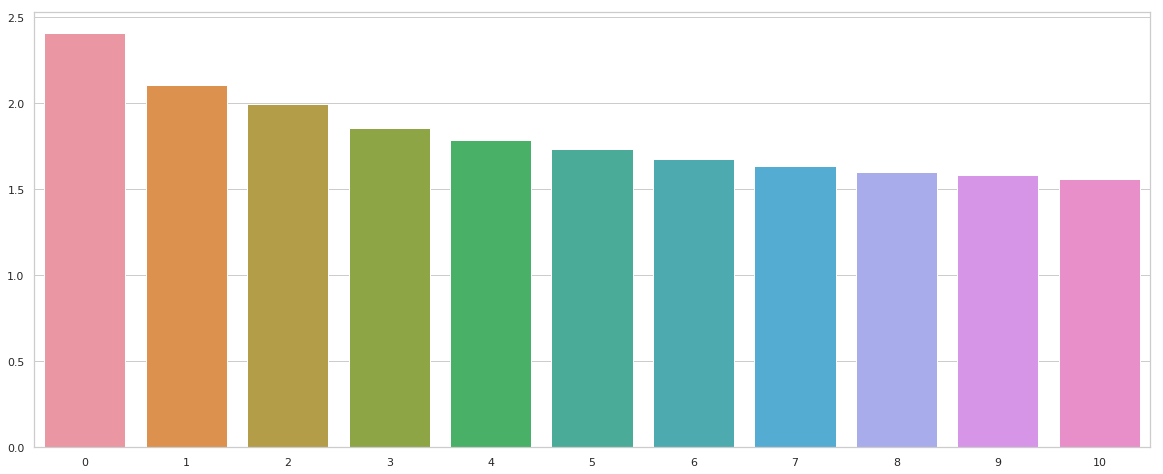

In [68]:


sns.barplot(y=model_summary.objectiveHistory, x=list(range(len(model_summary.objectiveHistory))))


In [69]:
label_stats = {float(i):{'index': float(i)} for i in range(34)}
for i, rate in enumerate(model_summary.falsePositiveRateByLabel):
    label_stats[i]['false_positive_rate'] = rate
    
for i, rate in enumerate(model_summary.truePositiveRateByLabel):
    label_stats[i]['true_positive_rate'] = rate
    
for i, rate in enumerate(model_summary.precisionByLabel):
    label_stats[i]['precision_rate'] = rate
    
for i, rate in enumerate(model_summary.recallByLabel):
    label_stats[i]['recall_rate'] = rate
    
for i, rate in enumerate(model_summary.fMeasureByLabel()):
    label_stats[i]['f_measure'] = rate

In [70]:
train_rdd = train.select(['Primary Type', 'primary_type_indexed']).distinct().orderBy('primary_type_indexed').rdd.map(lambda l: l.asDict()).collect()

In [71]:
for l in train_rdd:
    print(l)
    label_stats[l['primary_type_indexed']]['Primary Type'] = l['Primary Type']

{'Primary Type': 'THEFT', 'primary_type_indexed': 0.0}
{'Primary Type': 'BATTERY', 'primary_type_indexed': 1.0}
{'Primary Type': 'CRIMINAL DAMAGE', 'primary_type_indexed': 2.0}
{'Primary Type': 'NARCOTICS', 'primary_type_indexed': 3.0}
{'Primary Type': 'OTHER OFFENSE', 'primary_type_indexed': 4.0}
{'Primary Type': 'ASSAULT', 'primary_type_indexed': 5.0}
{'Primary Type': 'BURGLARY', 'primary_type_indexed': 6.0}
{'Primary Type': 'MOTOR VEHICLE THEFT', 'primary_type_indexed': 7.0}
{'Primary Type': 'ROBBERY', 'primary_type_indexed': 8.0}
{'Primary Type': 'DECEPTIVE PRACTICE', 'primary_type_indexed': 9.0}
{'Primary Type': 'CRIMINAL TRESPASS', 'primary_type_indexed': 10.0}
{'Primary Type': 'PROSTITUTION', 'primary_type_indexed': 11.0}
{'Primary Type': 'WEAPONS VIOLATION', 'primary_type_indexed': 12.0}
{'Primary Type': 'PUBLIC PEACE VIOLATION', 'primary_type_indexed': 13.0}
{'Primary Type': 'OFFENSE INVOLVING CHILDREN', 'primary_type_indexed': 14.0}
{'Primary Type': 'CRIM SEXUAL ASSAULT', 'pr

In [72]:
rates_pddf = pd.DataFrame(list(label_stats.values()))


In [73]:
rates_pddf = rates_pddf.sort_values(by='precision_rate', ascending=False)


In [74]:
rates_pddf


,Primary Type,f_measure,false_positive_rate,index,precision_rate,recall_rate,true_positive_rate
0,THEFT,0.765016,0.129051,0.0,0.653782,0.921861,0.921861
11,PROSTITUTION,0.227756,0.000906,11.0,0.617828,0.139611,0.139611
3,NARCOTICS,0.698525,0.069411,3.0,0.597864,0.839943,0.839943
4,OTHER OFFENSE,0.188402,0.007173,4.0,0.513462,0.115366,0.115366
2,CRIMINAL DAMAGE,0.395926,0.046607,2.0,0.483013,0.335445,0.335445
1,BATTERY,0.428108,0.126597,1.0,0.428220,0.427996,0.427996
7,MOTOR VEHICLE THEFT,0.302904,0.016281,7.0,0.416102,0.238125,0.238125
6,BURGLARY,0.354511,0.062600,6.0,0.301740,0.429651,0.429651
9,DECEPTIVE PRACTICE,0.316258,0.030814,9.0,0.295988,0.339509,0.339509
10,CRIMINAL TRESPASS,0.172970,0.010080,10.0,0.272213,0.126757,0.126757


### Test

In [77]:
prediction = fittedModel.transform(test)

In [78]:
prediction.select('Primary Type','rawPrediction', 'probability', 'prediction').show()

+-------------------+--------------------+--------------------+----------+
|       Primary Type|       rawPrediction|         probability|prediction|
+-------------------+--------------------+--------------------+----------+
|            BATTERY|[-4.5424786837682...|[1.12698759923920...|       8.0|
|      OTHER OFFENSE|[0.86620628140428...|[5.14258441530624...|       1.0|
| DECEPTIVE PRACTICE|[-3.2251996186921...|[5.96286215001331...|       5.0|
|            BATTERY|[-4.7735306448039...|[9.22464508304825...|       9.0|
|      OTHER OFFENSE|[3.42162124335793...|[0.04545171064829...|       1.0|
|MOTOR VEHICLE THEFT|[1.37850659446378...|[0.00541140772930...|       2.0|
|              THEFT|[10.5316583395454...|[0.83068566203388...|       0.0|
|    CRIMINAL DAMAGE|[5.34762997087535...|[0.20544779195797...|       2.0|
|      OTHER OFFENSE|[1.05039575619955...|[0.00561661402345...|       3.0|
|MOTOR VEHICLE THEFT|[1.48141433258335...|[0.00575096295376...|       2.0|
|            ASSAULT|[1.2

In [79]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction",labelCol="primary_type_indexed")
print('Test Area Under ROC', evaluator.evaluate(prediction))

Test Area Under ROC 0.17371402535154468
